In [3]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    'font.size': 20,
    'figure.figsize': (12, 6)
})
plt.rc('font', family='arial')

In [4]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-labs/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

In [5]:
GC_WINDOW_SIZE = 1000

## Non-exonic non-enhancer Chen windows, with Gnocchi, and various features (e.g. GC content)

In [6]:
import polars as pl

def get_unconstrained_noncoding_chen_windows(): 
    df = pl.read_csv(
        # non-exonic windows
        f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.features.constraint_scores.bed', 
        separator='\t',
    )
    df = df.filter(pl.col('window overlaps enhancer') == False) # putatively unconstrained windows 
    df = df.to_pandas()
    return df 
    
UNCONSTRAINED_NONCODING_CHEN_WINDOWS = get_unconstrained_noncoding_chen_windows()
UNCONSTRAINED_NONCODING_CHEN_WINDOWS

,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi,depletion_rank_constraint_score,depletion_rank_constraint_score_complement
0,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657,0.679834,0.320166
1,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925,0.320987,0.679013
2,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243,0.718503,0.281497
3,chr1,1467000,1468000,2.958469,273,False,False,0.651,0.039046,0.025852,...,2.585568,0.636364,0.552345,0.583014,0.574087,NaN,False,326.453703,0.805056,0.194944
4,chr1,1476000,1477000,-0.662737,301,False,False,0.651,0.039046,0.025852,...,2.585568,0.556444,0.595440,0.582994,0.573887,NaN,False,289.719448,0.883274,0.116726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
693265,chr9,137136000,137137000,3.277688,258,False,False,0.555,0.150095,0.005393,...,2.281162,0.631369,0.551045,0.588594,0.583316,NaN,False,316.292417,0.558267,0.441733
693266,chr9,137137000,137138000,2.779895,254,False,False,0.555,14.102295,1.698819,...,2.281162,0.586414,0.559444,0.587014,0.583278,NaN,False,302.336307,0.422128,0.577872
693267,chr9,137138000,137139000,3.286597,219,False,False,0.556,0.150095,0.005393,...,2.281162,0.616384,0.584242,0.588514,0.583253,217.0,True,273.337005,0.002164,0.997836
693268,chr9,137146000,137147000,6.685589,237,False,False,0.556,0.004152,0.000249,...,2.281162,0.666334,0.620738,0.600204,0.582346,116.0,True,364.670293,0.545990,0.454010


## Non-exonic non-enhancer Chen windows, with lambda_s (Dukler et al), and various features (e.g. GC content)

In [5]:
def get_unconstrained_noncoding_chen_windows_with_lambda_s(): 
    # https://mail.google.com/mail/u/0/#inbox/QgrcJHrjCsBTxVdFdTZvkMTlDfGKRnDvZxl
    # http://compgen.cshl.edu/extrainsight/description.php
    df = pl.read_csv(
        f'{CONSTRAINT_TOOLS_DATA}/lambda_s/Results_26July2024.csv',
        infer_schema_length=1000000,
    )
    df = df.with_columns(
        df["start"].cast(pl.Int64),
        df["end"].cast(pl.Int64),
    )
    df = df.to_pandas()

    # Nurdan: "I've included the windows for which ExtRaINSIGHT does not report results, 
    # as they do not pass the filtering steps. 
    # In these cases, all values from columns 4 to 9 are 0."
    df = df[df['num_possible_mutations'] > 0]

    df = UNCONSTRAINED_NONCODING_CHEN_WINDOWS.merge(df, left_on=['chrom', 'start', 'end'], right_on=['chr', 'start', 'end'], how='inner')
    df = df.drop(columns=['chr'])

    # unnecessary: 
    # df = df[df['window overlaps enhancer'] == False] # putatively unconstrained windows 

    return df 
    
UNCONSTRAINED_NONCODING_CHEN_WINDOWS_WITH_LAMBDA_S = get_unconstrained_noncoding_chen_windows_with_lambda_s()
UNCONSTRAINED_NONCODING_CHEN_WINDOWS_WITH_LAMBDA_S

,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,window_overlaps_cpg_island,N_mean_null_gnocchi,depletion_rank_constraint_score,depletion_rank_constraint_score_complement,strong_selection,p,lr_stat,num_possible_mutations,curvature,se
0,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,False,302.590657,0.679834,0.320166,0.061982,0.374389,0.789047,2784,393.356816,0.050420
1,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,False,269.601925,0.320987,0.679013,0.103610,0.126727,2.332151,2838,418.212534,0.048899
2,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,False,270.583243,0.718503,0.281497,-0.019612,0.779494,0.078388,2826,386.265976,0.050881
3,chr1,1467000,1468000,2.958469,273,False,False,0.651,0.039046,0.025852,...,False,326.453703,0.805056,0.194944,0.116424,0.079345,3.078267,2838,437.646421,0.047801
4,chr1,1476000,1477000,-0.662737,301,False,False,0.651,0.039046,0.025852,...,False,289.719448,0.883274,0.116726,0.089140,0.209020,1.578199,2742,383.019819,0.051096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647108,chr9,137136000,137137000,3.277688,258,False,False,0.555,0.150095,0.005393,...,False,316.292417,0.558267,0.441733,0.109622,0.130260,2.289405,2778,370.014983,0.051986
647109,chr9,137137000,137138000,2.779895,254,False,False,0.555,14.102295,1.698819,...,False,302.336307,0.422128,0.577872,0.000113,1.000000,-0.000058,2796,350.872768,0.053386
647110,chr9,137138000,137139000,3.286597,219,False,False,0.556,0.150095,0.005393,...,True,273.337005,0.002164,0.997836,0.085462,0.231656,1.430662,2715,376.709344,0.051522
647111,chr9,137146000,137147000,6.685589,237,False,False,0.556,0.004152,0.000249,...,True,364.670293,0.545990,0.454010,0.239313,0.000509,12.082492,2784,421.703488,0.048696


## Non-exonic non-enhancer Halldorsson windows, with Depletion Rank score, and various features (e.g. GC content)

In [7]:
def get_unconstrained_noncoding_halldorsson_windows(testing=False): 
    # noncoding windows: 
    filename = f'{CONSTRAINT_TOOLS_DATA}/depletion_rank_scores/41586_2022_4965_MOESM3_ESM.noncoding.enhancer.BGS.gBGC.GC_content.bed'
    if testing: 
        df = pl.scan_csv(filename, separator='\t', n_rows=100000).collect()
    else:
        df = pl.read_csv(filename, separator='\t')

    df = df.with_columns((1-pl.col('depletion_rank')).alias('depletion_rank_constraint_score_complement'))
    df = df.to_pandas()
    df = df[df['window overlaps enhancer'] == False] # putatively unconstrained windows
    return df

UNCONSTRAINED_NONCODING_HALLDORSSON_WINDOWS = get_unconstrained_noncoding_halldorsson_windows()
UNCONSTRAINED_NONCODING_HALLDORSSON_WINDOWS

,chromosome,start,end,depletion_rank,enhancer_overlap,window overlaps enhancer,B,B_M1star.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,depletion_rank_constraint_score_complement
8,chr1,1383600,1384100,0.859994,NaN,False,0.653,0.108103,0.535465,0.547445,0.580274,0.140006
9,chr1,1383650,1384150,0.841543,NaN,False,0.653,0.108103,0.534466,0.547345,0.580314,0.158457
10,chr1,1383700,1384200,0.756193,NaN,False,0.653,0.108103,0.528472,0.547545,0.580294,0.243807
11,chr1,1383750,1384250,0.860080,NaN,False,0.653,0.108103,0.531469,0.548545,0.580294,0.139920
12,chr1,1383800,1384300,0.911652,NaN,False,0.653,0.108103,0.547453,0.550045,0.580224,0.088348
...,...,...,...,...,...,...,...,...,...,...,...,...
38632861,chr9,137985250,137985750,0.162180,NaN,False,0.536,0.165515,0.578422,0.518648,0.489205,0.837820
38632862,chr9,137985300,137985800,0.103548,NaN,False,0.536,0.165515,0.575425,0.519848,0.489175,0.896452
38632863,chr9,137985350,137985850,0.137103,NaN,False,0.536,0.165515,0.578422,0.520048,0.489265,0.862897
38632864,chr9,137985400,137985900,0.192227,NaN,False,0.536,0.165515,0.581419,0.520548,0.489265,0.807773


## Non-exonic non-enhancer CDTS windows, with CDTS score, and various features (e.g. GC content)

In [8]:
def get_unconstrained_noncoding_CDTS_windows(testing=False): 
    # noncoding windows:
    filename = f'{CONSTRAINT_TOOLS_DATA}/CDTS/CDTS.gnomAD.hg38.noncoding.enhancer.BGS.gBGC.GC_content.bed'

    if testing: 
        df = pl.scan_csv(filename, separator='\t', n_rows=100000).collect()
    else:
        df = pl.read_csv(filename, separator='\t')
    df = df.with_columns((100-pl.col('percentile_rank_of_observed_minus_expected')).alias('percentile_rank_of_observed_minus_expected_complement'))
    df = df.to_pandas()
    df = df[df['window overlaps enhancer'] == False] # putatively unconstrained windows
    return df

UNCONSTRAINED_NONCODING_CDTS_WINDOWS = get_unconstrained_noncoding_CDTS_windows()
UNCONSTRAINED_NONCODING_CDTS_WINDOWS

,chromosome,start,end,observed_counts,expected_counts,observed_minus_expected,percentile_rank_of_observed_minus_expected,enhancer_overlap,window overlaps enhancer,B,B_M1star.EUR,GC_content_1000bp,percentile_rank_of_observed_minus_expected_complement
50,chr1,1383599,1384150,14,15.013323,-1.013320,42.772443,NaN,False,0.653,0.108103,0.535465,57.227557
51,chr1,1383609,1384160,14,15.595469,-1.595470,36.565416,NaN,False,0.653,0.108103,0.536464,63.434584
52,chr1,1383619,1384170,15,15.980183,-0.980183,43.130249,NaN,False,0.653,0.108103,0.534466,56.869751
53,chr1,1383629,1384180,13,16.327684,-3.327680,20.000880,NaN,False,0.653,0.108103,0.534466,79.999120
54,chr1,1383639,1384190,13,16.369216,-3.369220,19.661385,NaN,False,0.653,0.108103,0.535465,80.338615
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193455898,chr17,58762584,58763135,16,16.767538,-0.767538,45.423107,NaN,False,0.536,0.226818,0.421578,54.576893
193455899,chr17,58762594,58763145,16,16.734729,-0.734729,45.776368,NaN,False,0.536,0.226818,0.420579,54.223632
193455900,chr17,58762604,58763155,16,16.730413,-0.730413,45.822940,NaN,False,0.536,0.226818,0.417582,54.177060
193455901,chr17,58762614,58763165,16,16.701082,-0.701082,46.137652,NaN,False,0.536,0.226818,0.414585,53.862348


## Linear regression: predicting constraint-scores (Gnocchi, lambda_s, etc) in putatively unconstrained noncoding windows as a function of GC_content, gBGC and BGS, and visualizing in heat maps and tables

In [7]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

def fit_linear_model(df, features, features_alias, target, target_alias):
    X = df[features]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    standardized_features = [f'standardized_{feature}' for feature in features]
    X = pd.DataFrame(X, columns=standardized_features)

    X = sm.add_constant(X)

    y = df[target]

    # TODO: check: 
    y = scaler.fit_transform(y.values.reshape(-1, 1))
    y = pd.Series(y.flatten())
    df[f'standardized_{target}'] = y

    model = sm.OLS(y, X)
    results = model.fit()
    
    y_pred = results.predict(X)
    y_pred = np.array(y_pred).reshape(-1, 1)
    df[f'predicted_{target}'] = scaler.inverse_transform(y_pred) # TODO: check, and use different name for this instance of StandardScaler
    
    rsquared_record = {
        'constraint score': target_alias,
        'features': features_alias,
        # proportion of variance in target explained by linear model
        # also known as the coefficient of multiple correlation: https://en.wikipedia.org/wiki/Coefficient_of_multiple_correlation
        # also see: https://chatgpt.com/share/5aed531e-5b01-466c-9ac8-ec1723d100c6
        # also see: https://chatgpt.com/share/87aabad1-81b5-4df9-addc-ce6ea0d15054 
        'R2': results.rsquared, 
    }

    coefficients = results.params
    standard_errors = results.bse
    pvalues = results.pvalues

    records = []
    for feature_alias, standardized_feature in zip(features_alias, standardized_features):
        for parameter in ['Estimated value', 'Standard error', 'p-value']:
            records.append({
                'constraint score': target_alias,
                'feature': feature_alias,
                'regression coefficient:': parameter, 
                'regression coefficient value': {
                    'Estimated value': coefficients[standardized_feature],
                    'Standard error': standard_errors[standardized_feature],
                    'p-value': pvalues[standardized_feature],
                }[parameter]
            })

    results_df = pd.DataFrame(records).reset_index(drop=True)
    
    results_df = results_df.pivot(
        index=["constraint score", "feature"], 
        columns=["regression coefficient:"], 
        values="regression coefficient value"
    )

    return results_df, rsquared_record

fit_linear_model(
    df=UNCONSTRAINED_NONCODING_CHEN_WINDOWS, 
    features=[f'GC_content_{GC_WINDOW_SIZE}bp'],
    features_alias=['GC content'],
    target='gnocchi',
    target_alias='gnocchi'
)

(regression coefficient:      Estimated value  Standard error  p-value
 constraint score feature                                             
 gnocchi          GC content         0.267142        0.001157      0.0,
 {'constraint score': 'gnocchi',
  'features': ['GC content'],
  'R2': 0.07136504880216765})

In [24]:
def plot_heat_map(df, feature, feature_alias, target, target_alias, ylim, hline_y_coord, min_windows=1):
    cmap='inferno'

    # from matplotlib.colors import LinearSegmentedColormap
    # # Create a colormap that goes from white to a less intense black
    # cmap = LinearSegmentedColormap.from_list(
    #     'custom', 
    #     [(0, 'white'), (1, '#444444')],  # '#444444' is a less intense black
    # )

    fig, (ax_joint, ax_colorbar) = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [5, 0.5]})

    for side in ['top', 'right']:
        ax_joint.spines[side].set_visible(False)

    ax_joint.set_ylim(ylim)

    hb = ax_joint.hexbin(
        df[feature], 
        df[target], 
        gridsize=50, 
        cmap=cmap, 
        norm=LogNorm(),  
        mincnt=min_windows,
    )

    df[f'{feature}_bin_midpoints'] = (pd
        .cut(df[feature], bins=20, labels=None)
        .apply(lambda x: (x.right + x.left) / 2)
    )

    average_target = df.groupby(f'{feature}_bin_midpoints')[target].mean()
    average_predicted_target = df.groupby(f'{feature}_bin_midpoints')[f'predicted_{target}'].mean()

    ax_joint.plot(average_target.index, average_target.values, color='red', lw=2, label=f'mean {target_alias}') 
    ax_joint.plot(average_predicted_target.index, average_predicted_target.values, color=(8/255, 255/255, 0/255), lw=2, label=f'predicted {target_alias}') # green

    ax_joint.axvline(df[feature].mean(), color='black', lw=1)
    ax_joint.axhline(hline_y_coord, color='black', lw=1)

    ax_joint.set_xlabel(feature_alias)
    ax_joint.set_ylabel(target_alias)

    cbar = plt.colorbar(hb, cax=ax_colorbar)
    cbar.set_label('number of unconstrained noncoding windows')

    plt.show()

def plot_heat_maps(df, features, features_alias, target, target_alias, ylim, hline_y_coord):
    for feature, feature_alias in zip(features, features_alias):
        plot_heat_map(df, feature, feature_alias, target, target_alias, ylim, hline_y_coord)

def fit_and_plot(df, features, features_alias, target, target_alias, ylim, hline_y_coord): 
    results_df, rsquared_record = fit_linear_model(df, features, features_alias, target, target_alias)
    plot_heat_maps(df, features, features_alias, target, target_alias, ylim, hline_y_coord)
    return results_df, rsquared_record

def fit_and_plot_wrapper(df, target, target_alias, ylim, hline_y_coord): 
    results_df, rsquared_record__all_features = fit_and_plot(
        df=df, 
        features=[f'GC_content_{GC_WINDOW_SIZE}bp', 'B', 'B_M1star.EUR'],
        features_alias=['GC content', 'BGS', 'gBGC'],
        target=target,
        target_alias=target_alias,
        ylim=ylim,
        hline_y_coord=hline_y_coord
    )
    _, rsquared_record__GC_content_only = fit_and_plot(
        df=df, 
        features=[f'GC_content_{GC_WINDOW_SIZE}bp'],
        features_alias=['GC content'],
        target=target, 
        target_alias=target_alias,
        ylim=ylim,
        hline_y_coord=hline_y_coord
    )
    return results_df, rsquared_record__all_features, rsquared_record__GC_content_only

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


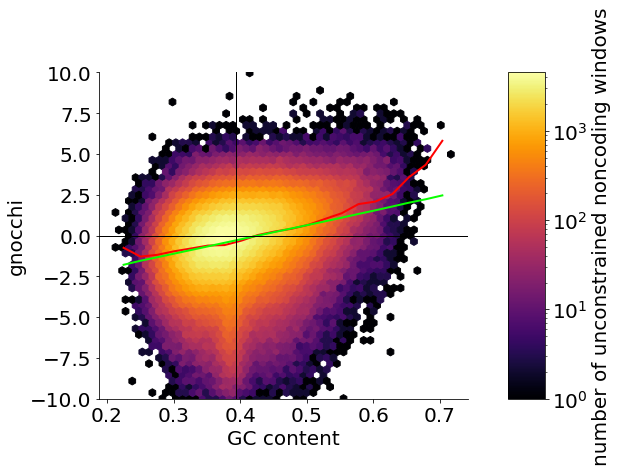

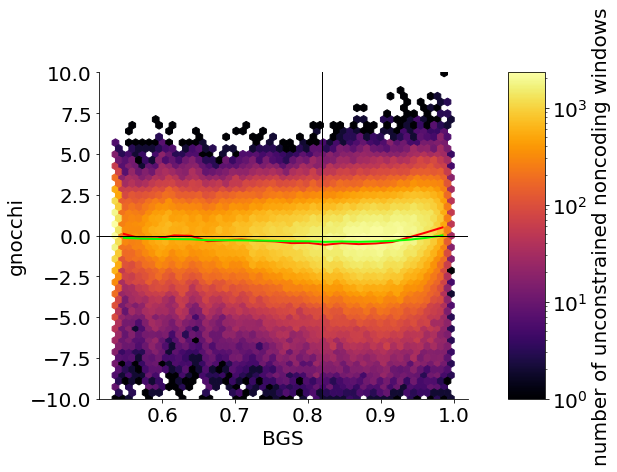

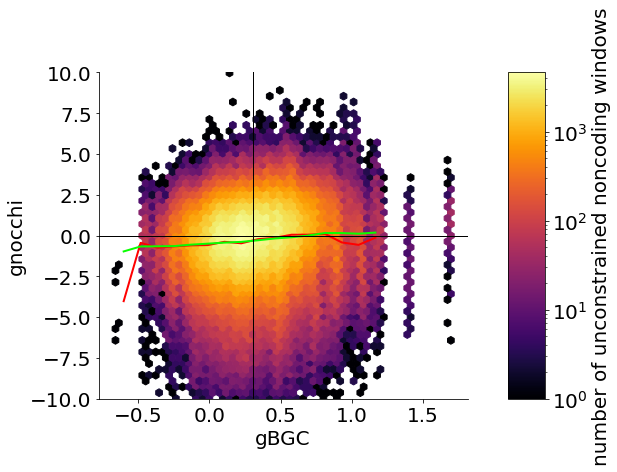

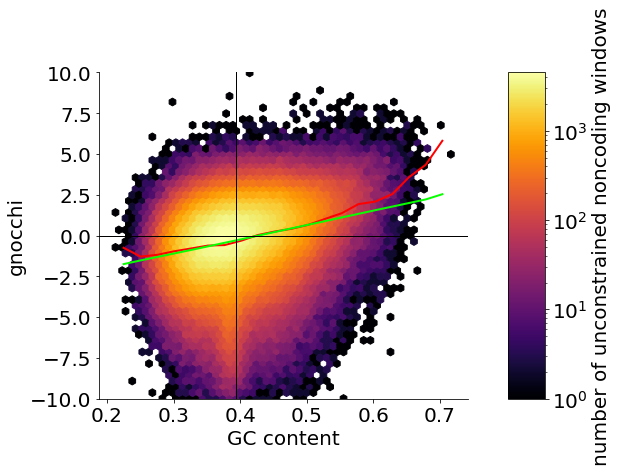

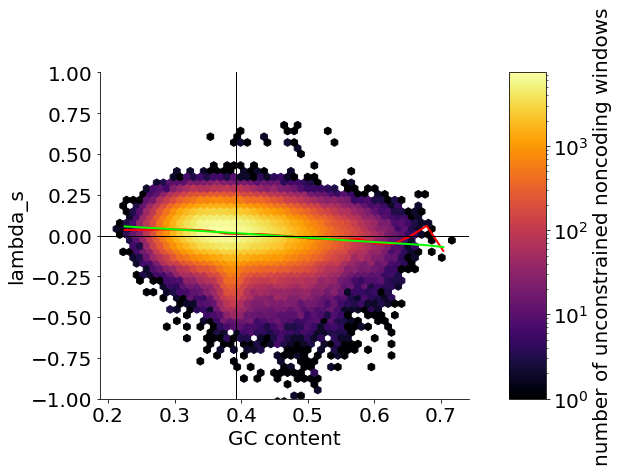

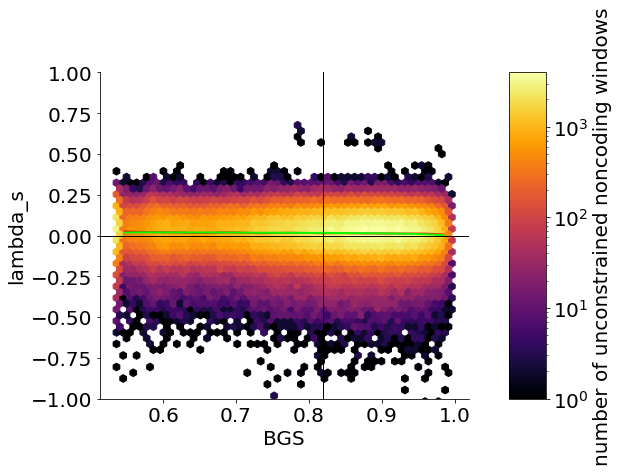

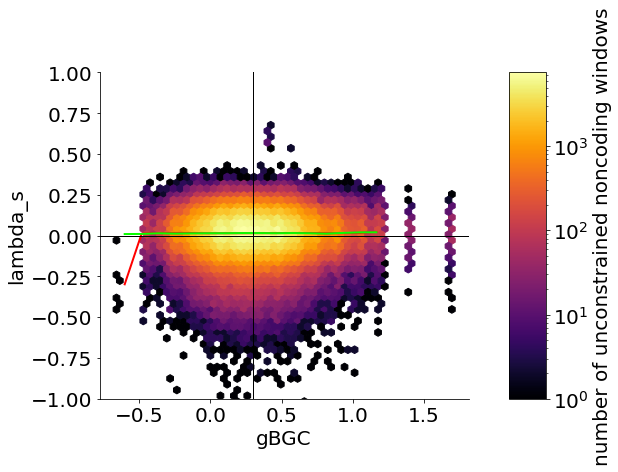

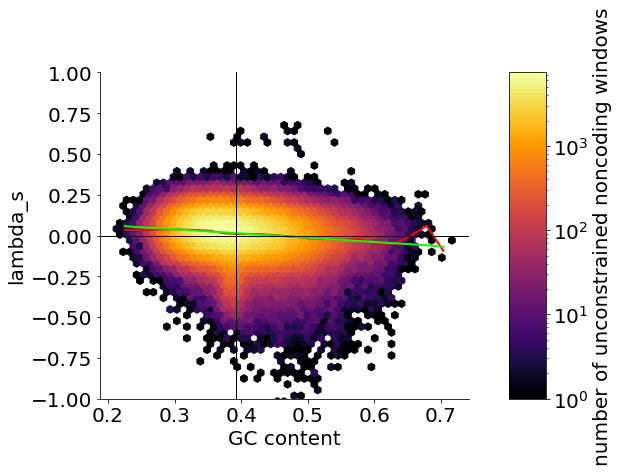

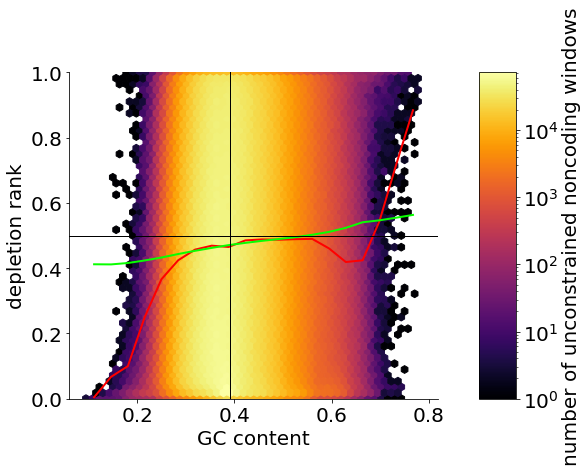

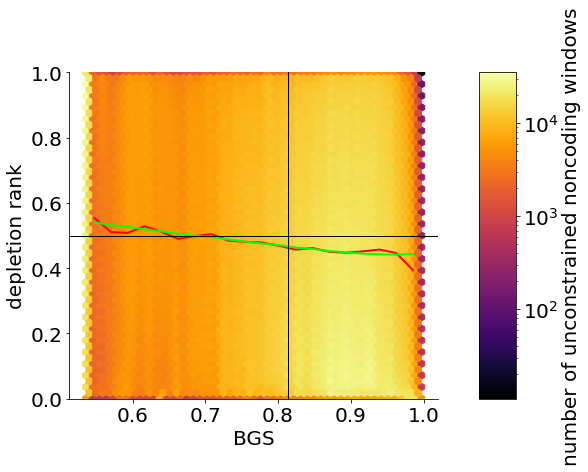

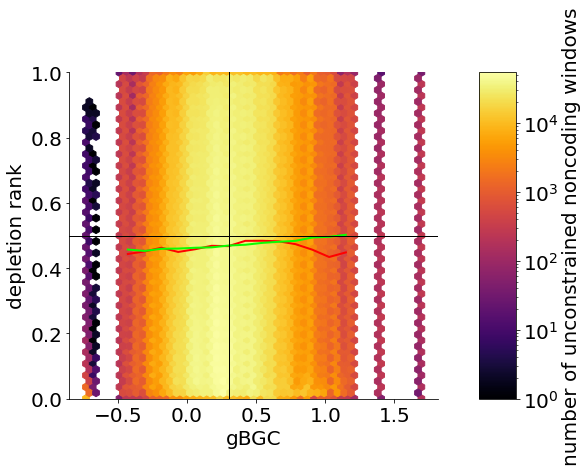

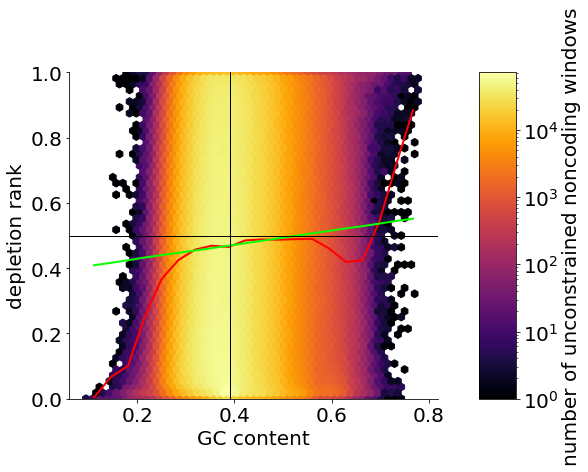

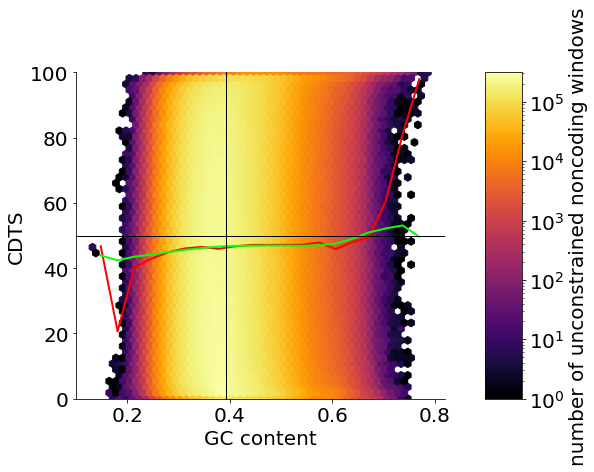

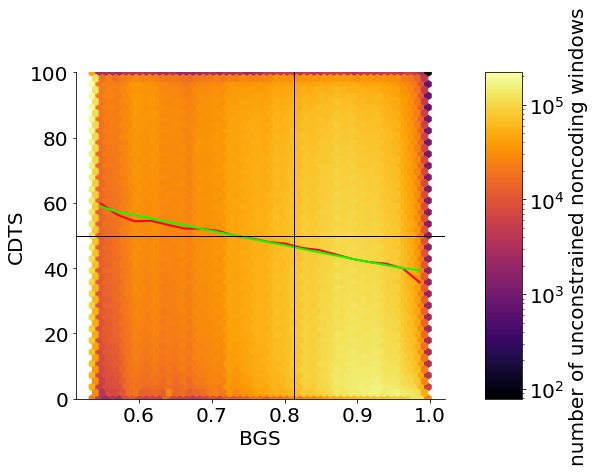

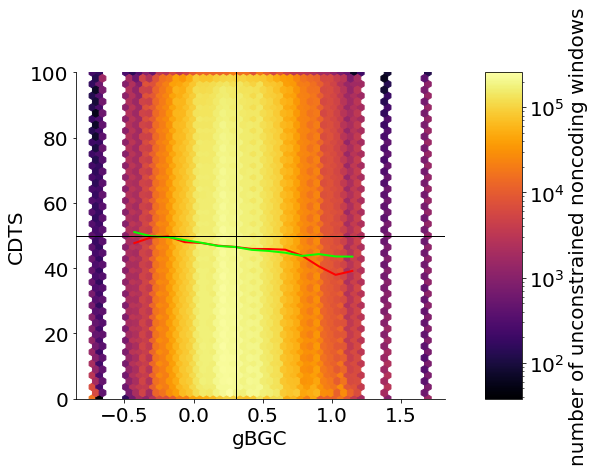

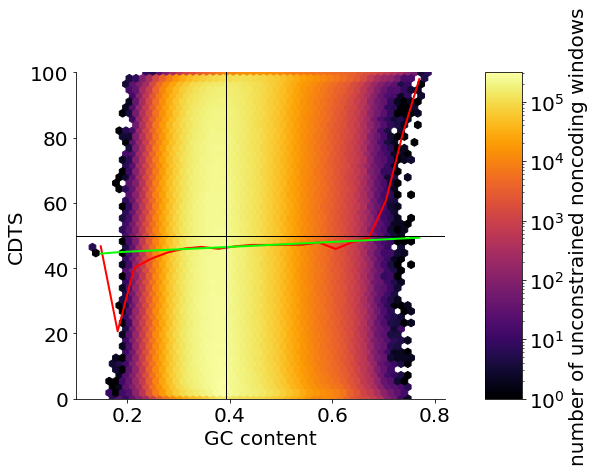

In [10]:
def plot_and_compute_beta_and_variance_explained():
    (
        regression_coefficient_gnocchi, 
        rsquared_record__all_features_gnocchi, 
        rsquared_record__GC_content_only_gnocchi
    ) = fit_and_plot_wrapper(
        UNCONSTRAINED_NONCODING_CHEN_WINDOWS, 
        'gnocchi', 
        'gnocchi', 
        ylim=(-10, 10),
        hline_y_coord=0
    )
    (
        regression_coefficient_lambda_s, 
        rsquared_record__all_features_lambda_s, 
        rsquared_record__GC_content_only_lambda_s
    ) = fit_and_plot_wrapper(
        UNCONSTRAINED_NONCODING_CHEN_WINDOWS_WITH_LAMBDA_S, 
        'strong_selection', 
        'lambda_s', 
        ylim=(-1, 1),
        hline_y_coord=0    
    )    

    (
        regression_coefficient_depletion_rank, 
        rsquared_record__all_features_depletion_rank, 
        rsquared_record__GC_content_only_depletion_rank
    ) = fit_and_plot_wrapper(
        UNCONSTRAINED_NONCODING_HALLDORSSON_WINDOWS, 
        'depletion_rank_constraint_score_complement', 
        'depletion rank', 
        ylim=(0,1),
        hline_y_coord=0.5
    )
    
    (
        regression_coefficient_CDTS, 
        rsquared_record__all_features_CDTS, 
        rsquared_record__GC_content_only_CDTS
    ) = fit_and_plot_wrapper(
        UNCONSTRAINED_NONCODING_CDTS_WINDOWS, 
        'percentile_rank_of_observed_minus_expected_complement', 
        'CDTS', 
        ylim=(0, 100),
        hline_y_coord=50
    )

    regression_coefficients = pd.concat([
        regression_coefficient_gnocchi,
        regression_coefficient_lambda_s,
        regression_coefficient_depletion_rank,
        regression_coefficient_CDTS
    ])

    rsquareds = pd.DataFrame([
        rsquared_record__all_features_gnocchi, 
        rsquared_record__GC_content_only_gnocchi,
        rsquared_record__all_features_lambda_s, 
        rsquared_record__GC_content_only_lambda_s,
        rsquared_record__all_features_depletion_rank, 
        rsquared_record__GC_content_only_depletion_rank,
        rsquared_record__all_features_CDTS, 
        rsquared_record__GC_content_only_CDTS
    ])
    
    return regression_coefficients, rsquareds

beta, proportion_of_variance_explained = plot_and_compute_beta_and_variance_explained()

In [13]:
beta

regression coefficient:      Estimated value  Standard error        p-value
constraint score feature                                                   
gnocchi          BGS               -0.040778        0.001175  8.425830e-264
                 GC content         0.261717        0.001169   0.000000e+00
                 gBGC               0.066182        0.001181   0.000000e+00
lambda_s         BGS               -0.021047        0.001249   1.117070e-63
                 GC content        -0.149008        0.001244   0.000000e+00
                 gBGC               0.028602        0.001256  9.027100e-115
depletion rank   BGS               -0.112495        0.000183   0.000000e+00
                 GC content         0.051595        0.000183   0.000000e+00
                 gBGC               0.039903        0.000185   0.000000e+00
CDTS             BGS               -0.190849        0.000081   0.000000e+00
                 GC content         0.034497        0.000081   0.000000e+00
                 gBGC              -0.021537        0.000082   0.000000e+00

In [12]:
proportion_of_variance_explained

,constraint score,features,R2
0,gnocchi,"[GC content, BGS, gBGC]",0.076448
1,gnocchi,[GC content],0.071365
2,lambda_s,"[GC content, BGS, gBGC]",0.022672
3,lambda_s,[GC content],0.021612
4,depletion rank,"[GC content, BGS, gBGC]",0.015118
5,depletion rank,[GC content],0.002434
6,CDTS,"[GC content, BGS, gBGC]",0.038306
7,CDTS,[GC content],0.000303


In [ ]:
# TODO: change DR and CDTS from quantile space to residual space, 
#       because otherwise the regression coefficients and R2s may not be comparable 
#       to those for gnocchi and lambda_s

In [ ]:
# TODO 

# change Table 1 so that it reports Yes or No for the question "significant?"
# change Table 2 so that the single-feature rows use the feature for which R2 is largest 
